*Josh Albano, Sharon Jan, and Luke Sherman*

*2020.5.12*

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import datetime
from pandas.plotting import register_matplotlib_converters
import geopandas as gp
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.tree import export_graphviz

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import re

from IPython.display import display, Latex, Markdown

# Research Question: Can counties' responses to COVID-19 accurately predict various political features?

In recent news, governments' responses to COVID-19 have been painted as highly partisan. We want to see if we can build models that accurately predict a county's 2016 presidential election results, using only features regarding counties' COVID-19 response.

# Load Datasets

### Datasets
- counties_df = County features dataframe (missing some counties, Alaska, and Hawaii)
- time_cases_df = Timeline of cases by county
- county_pres_df = Presidential election results by county
    - We added this dataset; this gives us our dependent political variables


### Cleaning steps
- Get rid of all non-US states (including territories & cruise ships).
- Get rid of Alaska & Hawaii in states, time_cases, and time_deaths because it is not in counties_df
- In time_cases & time_deaths, there are 'Out of State' & 'Unassigned' observations that seem like they're state-level. We split those off from the county-specific information for now.
- Convert FIPS columns to strings so they can be used as a merge key later. 
- Rename state FIPS "STATEFP" and county FIPS remains "FIPS"
- Get rid of most demographic features in counties_df; we only want to keep response features

In [2]:
def fips_to_string(df, fips_name, length=5):
    """
    Returns series of FIPS code in string form. Length tells you what length the string should be
    """
    return df[fips_name].apply(lambda x: '0' + str(int(x)) if len(str(int(x)))==length-1 \
                              else str(int(x)))

### Counties DF ####
counties_df = pd.read_csv("abridged_couties.csv")

counties_df = counties_df[counties_df['State'].notna()] #Get rid of US Territories
counties_df['STATEFP'] = fips_to_string(counties_df, 'STATEFP', length=2)
counties_df = counties_df.rename(columns={'countyFIPS': 'FIPS'}).drop(columns=['COUNTYFP'])
counties_keep_features = ['FIPS', 'STATEFP', 'CountyName', 'StateName', 'State','stay at home',
 '>50 gatherings',
 '>500 gatherings',
 'public schools',
 'restaurant dine-in',
 'entertainment/gym']
counties_old_df = counties_df.copy()
counties_df = counties_df[counties_keep_features] #Keep only COVID-19 response features (and FIPS ID)
counties_df['CountyName']

### Time Cases ###
time_cases_df = pd.read_csv("time_series_covid19_confirmed_US.csv")

time_cases_df = time_cases_df[time_cases_df['FIPS'].isna()==False]
time_cases_df['FIPS'] = fips_to_string(time_cases_df, 'FIPS', 5)
time_cases_df['STATEFP'] = time_cases_df['FIPS'].str[0:2]
FIPS = time_cases_df.pop('FIPS')
time_cases_df.insert(0, 'FIPS', FIPS)
STATEFP = time_cases_df.pop('STATEFP')
time_cases_df.insert(0, 'STATEFP', STATEFP)
#time_cases_df = time_cases_df[time_cases_df['STATEFP'].isin(['02','15'])==False] #Get rid of Alaska & Hawaii
state_time_cases = time_cases_df.groupby(['STATEFP','Province_State']).sum()
#Split off "Out of [State]" & "Unassigned" Data. Remove from df
# time_cases_df = time_cases_df[time_cases_df['STATEFP'].isin(['80','90'])==False]
time_cases_df = time_cases_df.drop(columns = ['UID', 'iso2', 'iso3', 'code3','Country_Region', 'Lat', 'Long_', 'Combined_Key'])

#County presidential election data
county_pres_df = pd.read_csv('countypres_2000-2016.csv')
county_pres_df = county_pres_df[(county_pres_df['party'] == 'democrat') | (county_pres_df['party'] == 'republican')]
county_pres_df['candidatevotes'].fillna(0, inplace=True)
county_pres_df.dropna(inplace=True)

county_pres_df = county_pres_df[(county_pres_df['county'] != 'Broomfield')]
#                                (county_pres_df['county'] != 'Kansas City') &
#                                (county_pres_df['county'] != 'Bedford')]

county_pres_df.loc[:, 'proportion'] = ((county_pres_df.loc[1::2, 'candidatevotes'].array - county_pres_df.loc[::2, 'candidatevotes'].array) 
                                       / county_pres_df.loc[1::2, 'totalvotes'])
county_pres_df.loc[::2, 'proportion'] = county_pres_df.loc[1::2, 'proportion'].array
county_pres_df['proportion'].fillna(0, inplace=True)
county_pres_df['FIPS'] = fips_to_string(county_pres_df, 'FIPS', 5)
county_pres_df['STATEFP'] = county_pres_df['FIPS'][0:2]
FIPS = county_pres_df.pop('FIPS')
county_pres_df.insert(0, 'FIPS', FIPS)
STATEFP = county_pres_df.pop('STATEFP')
county_pres_df.insert(0,'STATEFP',STATEFP)

# County shapefile
county_shp = gp.read_file('cb_2018_us_county_5m.shp')
county_shp = county_shp.loc[:, ('STATEFP', 'COUNTYFP', 'geometry')]
county_shp['FIPS'] = county_shp['STATEFP'] + county_shp['COUNTYFP']
county_shp = county_shp.drop(columns=['COUNTYFP'])
STATEFP = county_shp.pop('STATEFP')
county_shp.insert(0,'STATEFP', STATEFP)

## Dependent  Variables - Election Results

We have created some categorical and continuous political variables that we hope to explain using only counties' COVID-19 data. Essentially, using only information about COVID-19, can we predict a county/state's political leanings? In this section, we identify which party (Republican/Democratic) won each county's vote in presidential elections since 2000, and define a feature of the average vote across the past elections since 2000.

Ultimately, we choose to use only the 2016 election results to simplify our model (more information in the next section)

#### Functions for County-Level Election Data

In [3]:
def County_Winners(df, state, method='categorical'):
    """
    df: DataFrame
    state: U.S. State Name (e.g. California, Idaho, etc.)
    method: 
    
    Returns
    """
    assert method is 'categorical' or 'continuous', "Please choose either 'categorical' or 'continuous'"
    if method is 'categorical':
        max_col = 'party'
    elif method is 'continuous':
        max_col = 'proportion'
    
    state_df = df[df['state'] == state]

    election_years = state_df['year'].unique()
    winners_container = [[] for _ in range(len(election_years))]
    
    for idx, year in enumerate(election_years):
        winners = state_df[state_df['year'] == year].groupby('FIPS').apply(
            lambda county: county[max_col][county['candidatevotes'].idxmax()]).values
        winners_container[idx] = winners
            
    return winners_container

def County_Winners_DF(df, method='categorical'):
    """
    df: 
    
    Returns 
    """
    states = df['state'].unique()
    list_counties, list_fips = [], []
    list_2000, list_2004 = [], []
    list_2008, list_2012 = [], []
    list_2016 = []
    
    for state in states:
        state_df = df[df['state'] == state]
        fips = state_df['FIPS'].unique()
        county_winners = County_Winners(df=df, state=state, method=method)
        list_fips.extend(fips)
        list_2000.extend(county_winners[0])
        list_2004.extend(county_winners[1])
        list_2008.extend(county_winners[2])
        list_2012.extend(county_winners[3])
        list_2016.extend(county_winners[4])
    
    final_dataframe = pd.DataFrame({
    'FIPS': list_fips,
    '2000': list_2000, '2004': list_2004, 
    '2008': list_2008, '2012': list_2012,
    '2016': list_2016})
    
    if method is 'categorical':
        final_dataframe.replace({'republican': 1, 'democrat': 0}, inplace=True)
    else:
        pass
        
    final_dataframe['Total'] = final_dataframe.loc[:, ('2000', '2004', '2008', '2012', '2016')].mean(axis=1)
    
    return final_dataframe

In [4]:
# Dataframes with county-level data on presidential elections.

county_winners_cat_df = County_Winners_DF(county_pres_df)
county_winners_cont_df = County_Winners_DF(county_pres_df, method='continuous')

## Google Mobility Data

Here, we load in an additional dataset, [Google's Mobility Report](https://www.google.com/covid19/mobility/). This gives a measure of mobility before and during the COVID-19 crisis. Here's the description from the website:

*\"As global communities respond to COVID-19, we've heard from public health officials that the same type of aggregated, anonymized insights we use in products such as Google Maps could be helpful as they make critical decisions to combat COVID-19.*

*These Community Mobility Reports aim to provide insights into what has changed in response to policies aimed at combating COVID-19. The reports chart movement trends over time by geography, across different categories of places such as retail and recreation, groceries and pharmacies, parks, transit stations, workplaces, and residential."*

The Mobility data establishes a baseline for each county: this is the median "mobility value", for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020. For each subsequent week, the data reports the change in mobility relative to the baseline. Thus, a negative value means that mobility in a county has dropped below baseline levels.

In [5]:
# Clean mobility data
mob = pd.read_csv('Global_Mobility_Report.csv')
mob = mob[mob['country_region'] == 'United States'].iloc[:, 2:]
mob.reset_index(inplace=True)
mob.drop(columns='index', inplace=True)
new_cols = ['retail', 'grocery', 'parks', 'transit', 'workplaces', 'residential']
mob.columns = ['State', 'CountyName', 'date'] + new_cols
mob.loc[:, 'CountyName'] = mob.loc[:, 'CountyName'].str.replace(' County', '')
mob['date'] = pd.to_datetime(mob['date'])
mob.loc[:, 'date_ord'] = mob['date'].map(pd.Timestamp.toordinal)
mob = mob[(mob['State'] != 'Alaska') & (mob['State'] != 'Hawaii')]
mob.loc[(mob['State'] == 'Virginia'), 'CountyName'] = mob.loc[(mob['State'] == 'Virginia'), 'CountyName'].str.replace(' City', '')

for partitive in ['De', 'La', 'Du']:
    mob.loc[:, 'CountyName'] = mob.loc[:, 'CountyName'].str.replace(partitive+'[A-Z]', 
                               lambda m: m.group()[:2]+ ' ' +m.group()[2:], regex=True)

mob = mob[mob['date_ord'] > 737490]

# Create state level and county level mobility data
county_mob = mob[mob['CountyName'].isna() == False]
county_mob_pivoted = pd.pivot_table(county_mob, index=['State','CountyName'])
county_mob_pivoted.interpolate(inplace=True)

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Merge all datasets

Here we merge our datasets into "county_merged_df" to prepare for test train split:
- counties_df has our county-level COVID-19 orders
- county_winners_cat_df has our categorical political feature, 'VotedTrump2016'.
    - VotedTrump2016 = 1 if Trump won the county in 2016; 0 if not.
- county_winners_cont_df has our continuous political feature, 'VotedTrump2016Cont'.
    - $ VotedTrump2016Cont \in [-1,1]$ 
    - 0 means the county was split 50/50. 1.0 means that 100% of the county voted for Trump. -1.0 means that 0% voted for Trump.

Later on, we create two features using the time series data of COVID-19 cases by county, which is merged into our training data later.

In [6]:
county_merged_df = counties_df.merge(county_winners_cat_df.loc[:, ('FIPS', '2016')], on='FIPS')
county_merged_df.rename(columns={'2016': 'VotedTrump2016'}, inplace=True)
county_merged_df = county_merged_df.merge(county_winners_cont_df.loc[:, ('FIPS', '2016', 'Total')], on='FIPS')
county_merged_df.rename(columns={'2016': 'VotedTrump2016Cont', 'Total':'PresElectCont'}, inplace=True)
# Some counties have different naming conventions. Here we standardize some of those issues
county_merged_df.loc[:, 'CountyName'] = county_merged_df.loc[:, 'CountyName'].str.replace('St ', 'St. ')
county_merged_df.loc[(county_merged_df.StateName == 'VA'), 'CountyName'] = \
county_merged_df.loc[(county_merged_df.StateName == 'VA'), 'CountyName'].str.replace(' City', '')

county_merged_df = county_merged_df.merge(county_mob_pivoted, on=['State', 'CountyName'])
    
county_merged_df.head()

,FIPS,STATEFP,CountyName,StateName,State,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,...,VotedTrump2016,VotedTrump2016Cont,PresElectCont,date_ord,grocery,parks,residential,retail,transit,workplaces
0,01001,01,Autauga,AL,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,...,1,0.489969,0.471645,737516.0,8.607843,-37.666667,12.314286,-19.392157,NaN,-27.921569
1,01003,01,Baldwin,AL,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,...,1,0.571601,0.531744,737516.0,-2.470588,-5.666667,9.313725,-27.705882,-15.196078,-24.411765
2,01005,01,Barbour,AL,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,...,1,0.055688,0.025785,737516.0,-4.333333,-11.722222,9.999627,-4.030303,-21.119826,-18.470588
3,01007,01,Bibb,AL,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,...,1,0.551536,0.428398,737516.0,7.900000,-17.777778,10.685528,-3.633333,-27.043573,-22.000000
4,01009,01,Blount,AL,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,...,1,0.809090,0.659665,737516.0,5.040816,-23.833333,11.371429,-16.175000,-32.967320,-25.725490


#  Train Test Split

Time to split our data! We do an 80/20 split of all counties using the FIPS id. We shuffle the data, since the county data is ordered by alphabetically.

In [7]:
import sklearn.model_selection

def train_test_split_fips(unique_fips, fips_level, df):
    """
    Inputs:
    unique_fips = list of unique FIPS
    fips_level: either 'STATEFP' or 'FIPS'
    df_list: list of dataframes to train/test
    Returns:
    list of train/test splits of each dataframe: eg: [df1_train, df1_test, df2_train, df_test]
    """
    assert (fips_level == 'FIPS' or fips_level == 'STATEFP'), "Please enter 'STATEFP' or 'FIPS' for fips_level"

    #Train/Test Split FIPS IDs
    tr, te = sklearn.model_selection.train_test_split(
    unique_fips, train_size=0.8, test_size=0.2, random_state=47, shuffle=True)
    
    return df[df[fips_level].isin(tr)], df[df[fips_level].isin(te)]

In [8]:
#Unique Fips Codes
countyfp = county_merged_df['FIPS'].unique()

#County Level DFs (doesn't include states_df)
county_train, county_test = train_test_split_fips(countyfp, 'FIPS', county_merged_df)

print("County train size: ", county_train.shape[0], ", county test size: ", county_test.shape[0])

County train size:  2164 , county test size:  542


## County order features EDA

Below, we plot the change in workplace mobility between the counties with the highest and lowest vote for Trump 2016. Typically, the county with a high Trump vote has a slightly lower drop in mobility.

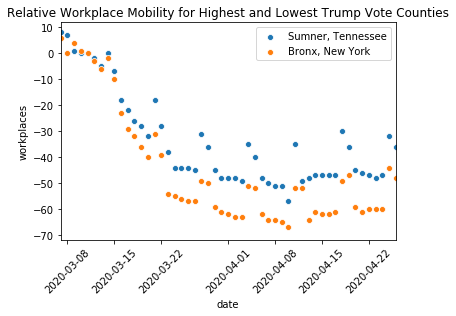

In [51]:
max_county = county_train.loc[county_train.dropna()['VotedTrump2016Cont'].idxmax()]['CountyName']
max_state = county_train.loc[county_train.dropna()['VotedTrump2016Cont'].idxmax()]['State']
min_county = county_train.loc[county_train['VotedTrump2016Cont'].idxmin()]['CountyName']
min_state = county_train.loc[county_train['VotedTrump2016Cont'].idxmin()]['State']

sns.scatterplot('date', 'workplaces', data=mob[(mob['CountyName'] == max_county) \
                & (mob['State'] == max_state)],
                label=max_county +", " + max_state)
sns.scatterplot('date', 'workplaces', data=mob[(mob['CountyName'] == min_county) \
                & (mob['State'] == min_state)], 
                label=min_county +", " + min_state)
plt.title('Relative Workplace Mobility for Highest and Lowest Trump Vote Counties')
plt.xlim(('2020-03-07'),('2020-04-26'))
plt.xticks(rotation=45)
plt.show()

This plot compares the date of stay at home orders and restricting gatherings to under 500 people by county. Both distributions seem roughly bimodal, but there are slightly more Republican counties with later restrictive orders. Dates are kept in ordinal time, which is easier to plot (plus we're not that interested in the actual date, just the relative order between counties).

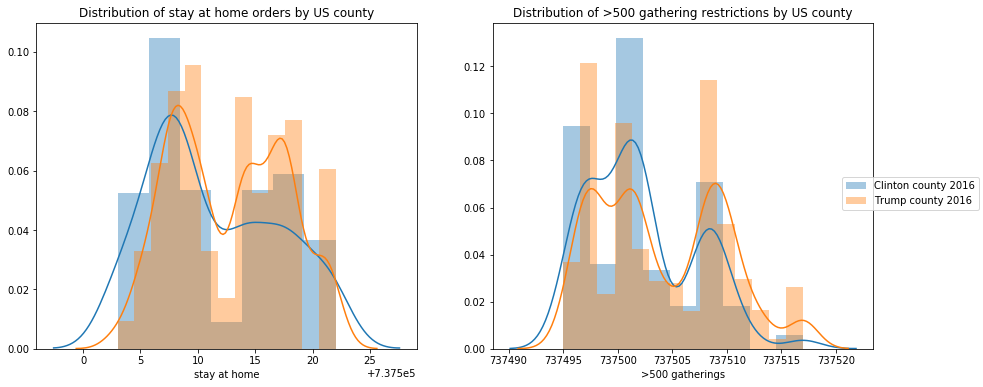

In [10]:
fig,ax = plt.subplots(1,2, figsize=(15,6))


for trump in range(0,2):
    county_sub = county_train[county_train["VotedTrump2016"]== trump]
    sns.distplot(county_sub["stay at home"].dropna(), ax = ax[0])
fig.legend(["Clinton county 2016", "Trump county 2016"], loc=7)

plt.title("Distribution of stay at home orders by US county")

for trump in range(0,2):
    county_sub = county_train[county_train["VotedTrump2016"]== trump]
    sns.distplot(county_sub[">500 gatherings"].dropna(), ax=ax[1])


ax[0].set_title("Distribution of stay at home orders by US county")

ax[1].set_title("Distribution of >500 gathering restrictions by US county")
plt.show()
#fig.savefig('ordersdist.png')

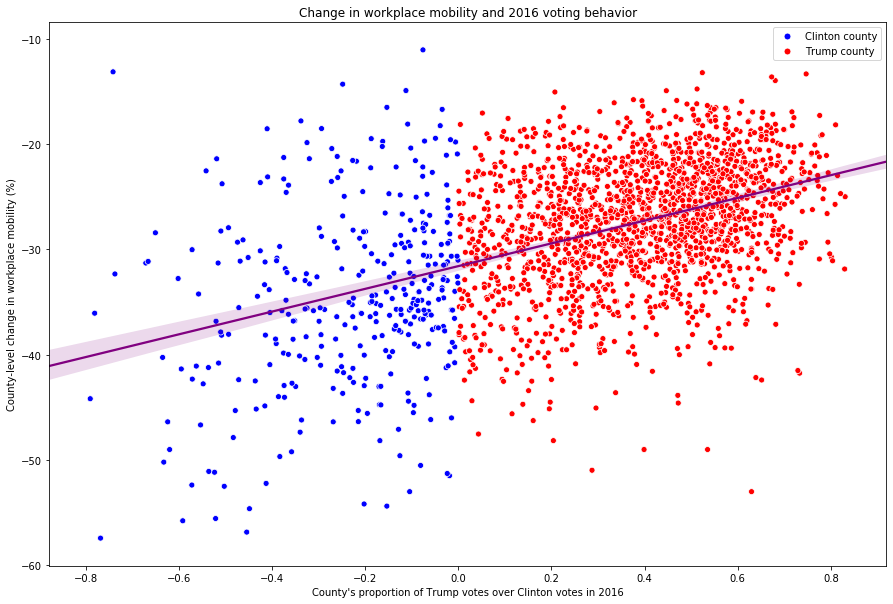

In [11]:
fig, ax = plt.subplots(1, figsize=(15,10))

g = sns.scatterplot(y= "workplaces", x="VotedTrump2016Cont",hue="VotedTrump2016" , data=county_train, palette=['blue','red'])
g = sns.regplot(y= "workplaces", x="VotedTrump2016Cont", scatter=True, data=county_train, color="purple",scatter_kws={"alpha": 0})
#f = sns.scatterplot(y= "workplaces", x="VotedTrump2016Cont",hue="VotedTrump2016" , data=county_train, palette=['blue','red'])


ax.set_title("Change in workplace mobility and 2016 voting behavior")
ax.set_xlabel("County's proportion of Trump votes over Clinton votes in 2016")
ax.set_ylabel("County-level change in workplace mobility (%)")

legend_elements=[Line2D([0], [0], marker='o', color='w', label='Clinton county',
                          markerfacecolor='blue', markersize=7),
                 Line2D([0], [0], marker='o', color='w', label='Trump county',
                          markerfacecolor='red', markersize=7)]
ax.legend(title="", handles = legend_elements)


# State Order Features

Creates some new features to describe: 
- Earliest order in state (for all orders)
- Latest order in state (for all orders)
- Whether state had same order across the state (for all orders)
- County's order date relative to state

In [12]:
# This function converts ordinal date to pandas date

def convert_ordinal_date_series_to_pd_date(series_object):
    """
    This function takes a series object of ordinal dates (days from the beginning of the 
    Gregorian calendar) and returns a pandas date time object series
    """
    #series_object = series_object.astype(int)
    k = []
    y = 0
    
    for ordinal_date in series_object:
        if np.isnan(ordinal_date) == True:
            y += 1
            k.append(np.nan)
            
        else:
            ordinal_date = int(ordinal_date)
            k.append(pd.to_datetime(datetime.datetime.fromordinal(ordinal_date)))
    print("Your series has", y, "NaNs. This function converts them to NaTs.")
    return pd.Series(k, index = series_object.index)

In [13]:
def state_orders_features(df, col, statefp= 'STATEFP'):
    """
    Inputs: df (dataframe), column (string of column name), statefp = STATEFP column
    Outputs a list of series: 
    1) The earliest date for the order, 
    2) The latest date for the order,
    3) Whether every county in the state has the same date of order (most likely a state order)
    4) Whether a county's order was before the median of the state (assuming the median will be the state order)
    """
    return [df[col].groupby(df[statefp]).transform(min),
            df[col].groupby(df[statefp]).transform(max),
            df[col].groupby(df[statefp]).transform(min) == df[col].groupby(df[statefp]).transform(max),
            df[col] - df[col].groupby(df[statefp]).transform('median')]

def add_state_orders_features_to_df(df, orders_columns, statefp = 'STATEFP'):
    """
    Adds state_orders_features to dataframe
    """
    for col in orders_columns:
        df['Earliest '+ col] = state_orders_features(df, col, statefp)[0]
        df['Latest '+ col] = state_orders_features(df, col, statefp)[1]
        df[col + ' same for whole state'] = state_orders_features(df, col, statefp)[2]
        df[col + ' relative to state'] = state_orders_features(df, col, statefp)[3]
    return df

In [14]:
# Apply state_orders_features and add_state_orders_features_to_df 

pd.set_option('mode.chained_assignment', None) #this is to make that slice error go away
orders_columns = ['stay at home', '>50 gatherings',
       '>500 gatherings', 'public schools', 'restaurant dine-in',
       'entertainment/gym']

county_train = add_state_orders_features_to_df(county_train, orders_columns)

In [15]:
county_train.head()

,FIPS,STATEFP,CountyName,StateName,State,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,...,public schools same for whole state,public schools relative to state,Earliest restaurant dine-in,Latest restaurant dine-in,restaurant dine-in same for whole state,restaurant dine-in relative to state,Earliest entertainment/gym,Latest entertainment/gym,entertainment/gym same for whole state,entertainment/gym relative to state
1,01003,01,Baldwin,AL,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,...,True,0.0,737503.0,737503.0,True,0.0,737512.0,737512.0,True,0.0
3,01007,01,Bibb,AL,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,...,True,0.0,737503.0,737503.0,True,0.0,737512.0,737512.0,True,0.0
4,01009,01,Blount,AL,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,...,True,0.0,737503.0,737503.0,True,0.0,737512.0,737512.0,True,0.0
5,01011,01,Bullock,AL,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,...,True,0.0,737503.0,737503.0,True,0.0,737512.0,737512.0,True,0.0
6,01013,01,Butler,AL,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,...,True,0.0,737503.0,737503.0,True,0.0,737512.0,737512.0,True,0.0


Ultimately, we decided to use the original order dates that were included in the counties dataset, rather than the new features showing their order date relative to the state order. As you can see below, the vast majority of counties had the same stay at home order as their state.

In [16]:
county_train['stay at home relative to state'].value_counts()

 0.0     1818
-9.0       16
-2.0       10
-5.0        8
-13.0       6
-6.0        5
-4.0        5
-7.0        4
-10.0       3
-8.0        3
-14.0       2
-12.0       2
-1.5        1
 1.5        1
-11.0       1
-15.0       1
Name: stay at home relative to state, dtype: int64

# Characterizing time series data (disease growth)

### Simple time series model

A simple way to think about the time series data would be to fit it with a simple quadratic equation of the form:

$new.cases_i = \beta_1~time_i + \beta_2~time_i^2$

Where $i$ is used to indicate a county-level observations and time is given in days since some threshold number of total cases in the county (outbreak begin).

The advantage of this model, is that it characterizes the curve with just two parameters. Because the growth should begin at (0,0) there is no need for an intercept parameter. Functionally, this forces the quadratic to go through the origin.

Functions to calculate this model for counties is below. It includes a plotting option as well as an option for the inclusion of an intercept.

In [17]:
#This function re-reads the dataset. We're probably not keeping the quadratic function features so I think its fine

def quadratic_time_series_model_daily_cases(county, threshold=300, min_observation_days=15, plot=False, intercept=False):
    """
    Function to get beta values for a quadratic time series model.
    Use county variable to specify the FIPS code for the relevant region. 
    Threshold is a scalar for the total number of cases in a region before beginning the model.
    Has an option to generate a basic plot when plot = True.
    Minimum observation days sets a minimum number of days since the threshold case value was reached to calculate the model.
    If the minimum observation days are not met, the function returns a list of nans.
    
    Returns a list of intercept, beta_1, and beta_2 in the model below
    
    daily_new_cases = beta_0 + beta_1*days_since_threshold_cases + beta_2*days_since_threshold_cases^2
    """
    time_cases_df = pd.read_csv("time_series_covid19_confirmed_US.csv") 
    pd.set_option('mode.chained_assignment', None)
    ids = ["FIPS","Admin2", "Province_State", "Country_Region"]
    date_column_begin = 11

    df = time_cases_df[ids + list(time_cases_df.columns[date_column_begin:])]
    df = df[-df["FIPS"].isna()] #drop cases with no FIPS ID
    df = df.melt(ids).rename(columns = {"value" : "cases"})
    date = pd.to_datetime(df["variable"], format="%m/%d/%y")
    df["date"] = date
    
    county_df = df.pivot_table(values = "cases", index = [ "FIPS", "date", "Admin2", "Province_State"],  aggfunc=sum).reset_index()
    county_df = county_df[county_df["FIPS"]==county]
    
    zero = np.array([0])
    new_cases_array = np.concatenate([zero, np.diff(county_df["cases"])])
    county_df.loc[:,"daily_new_cases"] = (new_cases_array) #Error here: A value is trying to be set on a copy of a slice from a DataFrame
    county_df = county_df[county_df["cases"] >= threshold]
    
    if len(county_df) < min_observation_days:
        return [np.nan, np.nan, np.nan]
    else:    
        county_df["days_since_threshold"] = np.arange(0,len(county_df))
        county_df["days_since_threshold^2"] = county_df["days_since_threshold"]**2

        lm = LinearRegression(fit_intercept=intercept)

        x = county_df[["days_since_threshold","days_since_threshold^2"]]
        y = np.array(county_df["daily_new_cases"]).reshape(-1,1)

        lm.fit(x,y)

        if plot == True:
            y_hat = lm.predict(x)
            plt.plot(county_df["days_since_threshold"], (county_df["daily_new_cases"]))
            plt.plot(county_df["days_since_threshold"], y_hat)

            plot_title_string = county_df["Admin2"].iloc[0] + ", " + county_df["Province_State"].iloc[0] + " FIPS: " + str(int(county_df["FIPS"].iloc[0]))
            plt.title("Quadratic modeling of daily cases for {}".format(plot_title_string))
            plt.ylabel("Daily new cases")
            plt.xlabel("days since {} cases".format(threshold))

        if intercept == True:
            return [lm.intercept_[0], lm.coef_[0][0], lm.coef_[0][1]]
        else:
            return [0, lm.coef_[0][0], lm.coef_[0][1]]
        
def create_county_beta_table(threshold=300, min_observation_days=15, intercept=False):
    time_cases_df = pd.read_csv("time_series_covid19_confirmed_US.csv") 
    pd.set_option('mode.chained_assignment', None)
    
    ids = ["FIPS","Admin2", "Province_State", "Country_Region"]
    date_column_begin = 11
    df = time_cases_df[ids + list(time_cases_df.columns[date_column_begin:])]   
    df = df[-df["FIPS"].isna()] #drop cases with no FIPS ID  
    df = df.melt(ids).rename(columns = {"value" : "cases"})
    date = pd.to_datetime(df["variable"], format="%m/%d/%y")
    df["date"] = date    
    df = df.pivot_table(values = "cases", index = [ "FIPS", "date", "Admin2", "Province_State"],  aggfunc=sum).reset_index()
    
    zero = np.array([0])  
    k = [] 
    for county in np.unique(time_cases_df["FIPS"]):    
        county_df = df[df["FIPS"]==county]   
        new_cases_array = np.concatenate([zero, np.diff(county_df["cases"])])
        county_df.loc[:,"daily_new_cases"] = (new_cases_array) #Error here: A value is trying to be set on a copy of a slice from a DataFrame
        county_df = county_df[county_df["cases"] >= threshold]
        if len(county_df) < min_observation_days:
            k.append([np.nan, np.nan, np.nan])
        else:
            county_df["days_since_threshold"] = np.arange(0,len(county_df))
            county_df["days_since_threshold^2"] = county_df["days_since_threshold"]**2

            lm = LinearRegression(fit_intercept=intercept)
            x = county_df[["days_since_threshold","days_since_threshold^2"]]
            y = np.array(county_df["daily_new_cases"]).reshape(-1,1)
            lm.fit(x,y)      
            if intercept == True:
                k.append([lm.intercept_[0], lm.coef_[0][0], lm.coef_[0][1] ])
            else:
                k.append([0, lm.coef_[0][0], lm.coef_[0][1] ])
            
    county_betas = pd.DataFrame(k).rename(columns = {0:"beta0",1:"beta1",2:"beta2"})
    county_betas.index = np.unique(time_cases_df["FIPS"])
    
    return county_betas



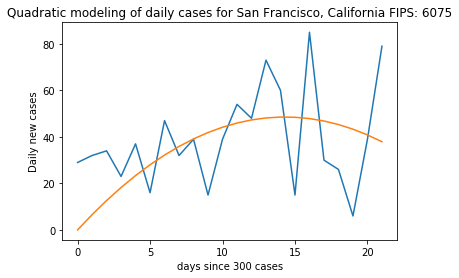

In [18]:
quadratic_time_series_model_daily_cases(6075, plot=True, intercept=False)
fig.savefig("quadraticSF.png")

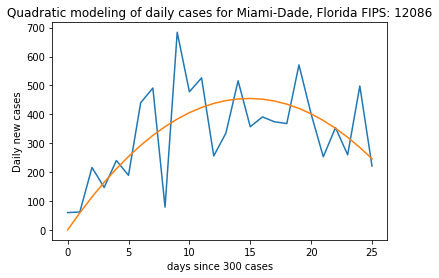

In [19]:
quadratic_time_series_model_daily_cases(12086, plot=True, intercept=False)
fig.savefig("quadraticMiami.png")

Now let's look at the distribution of these beta values with respect to our political features.

In [20]:
county_train["numeric_FIPS"] = pd.to_numeric(county_train["FIPS"])
county_train = pd.merge(county_train, create_county_beta_table(), left_on="numeric_FIPS", right_index=True)

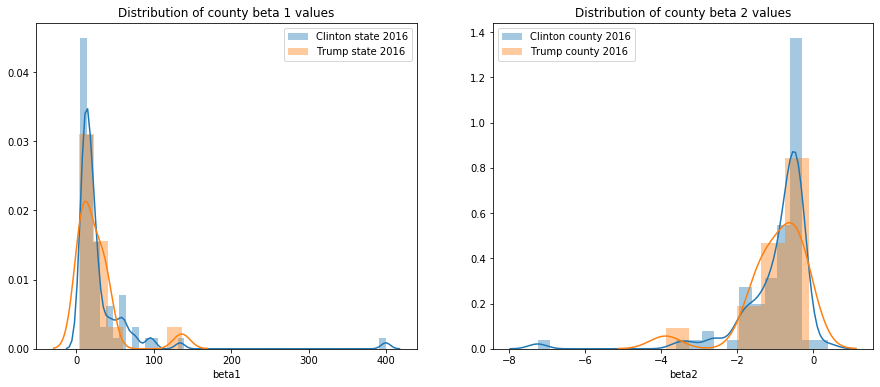

In [21]:
fig,ax = plt.subplots(1,2, figsize=(15,6))

for trump in range(0,2):
    county_sub = county_train[county_train["VotedTrump2016"]== trump]
    sns.distplot(county_sub["beta1"].dropna(), ax=ax[0])
    
ax[0].legend(["Clinton state 2016", "Trump state 2016"])
ax[0].set_title("Distribution of county beta 1 values")

for trump in range(0,2):
    county_sub = county_train[county_train["VotedTrump2016"]== trump]
    sns.distplot(county_sub["beta2"].dropna(), ax=ax[1])
    
ax[1].legend(["Clinton county 2016", "Trump county 2016"])
ax[1].set_title("Distribution of county beta 2 values")
fig.savefig("betadist.png")

Unfortunately, it looks like the quadratic model doesn't really show much variance. States with large outbreaks have higher much higher $\beta_1$ and $\beta_2$ values in absolute terms, but both parameters primarily just serve to characterize outbreak size in a county.

## Estimating the Effective Reproductive Number (R)

The issue with the quadratic model is that it really just shows the intensity of the outbreaks, not the true rate of transmission. This is because it has the incorrect functional form. Disease outbreaks should be modeled as exponentials. Epidimiologists use the Reproductive Number $R$ to describe disease outbreaks.

I'm going to now build a function to produce a simple estimate of the Effective Reproductive Number $R$ so that we can use it as a parameter in our models. This should better characterize the multipication of the disease irrespective of how large the outbreak is any given region. 

More information here:

https://en.wikipedia.org/wiki/Basic_reproduction_number

***

**Equations from wikipedia:**

$R=e^{K\tau}$

$K = \cfrac{d}{dt} ln(N(t))$

$\tau = \text{the serial interval}$

$N(t) = \text{an exponential time series for the number of cases over time (t). Here time is denoted in days.}$


***

**My own math for these calculations:**

The time series can be modeled by exponential growth in the equation below:

$N(t) = e^{kt}$

Now we use algebra and calculus to solve for $K$. Note that capital $K $ and lower-case $k$ are different variables here that are shown to be equal.

$ln(N(t)) = ln(e^{kt})$


$ln(N(t)) = kt*ln(e)$

$ln(N(t)) = kt$

$\frac{d}{dt}ln(N(t)) = k$

$R=e^{k\tau}$

***
Let's start by estimating  $R$ based off only the last 3 weeks (21 days). The reasoning for this is that a variety of factors related to behavioral and political intervention should have a differential effect on $R$. In the early stages of this outbreak, we might expect less consistent efforts.

Note that $R$ estimations also requre a serial interval $\tau$ that indicates how many days it take for each person to spread the disease. I'm estimating that it takes 7 days in the function below, based on media reports.

In [22]:
def calculate_R(state_or_FIPS, start_date=67, end_date=88, serial_interval = 7, min_obs=15):
    """
    calculates R value using either State names (must be strings) or FIPS codes (must be numeric). 
    Altetantively, input a Pandas Series object of state strings or FIPS codes.
    
    Specify time series start date and end date over the period day 0 to day 88
    
    Serial interval is the time lag (in days) for the spread of the disease
    
    min obs is a minimum number of observed case reporting days for each instance
    
    Returns the basic reproductive number R, and the associated K
    
    LaTeX FORMULAS
    
    $R_0=e^{K~\tau}$

    $K = \cfrac{d~ ln(N(t))}{dt}$

    $\tau = \text{the serial interval}$

    $N(t) = \text{an exponential time series for the number of cases over time (t}$

    """

    pd.set_option('mode.chained_assignment', None) 
    ids = ["FIPS","Admin2", "Province_State"]
    date_column_begin = 4
    df = time_cases_df[ids + list(time_cases_df.columns[date_column_begin:])]  
    df["FIPS"] = pd.to_numeric(df["FIPS"])   
    df = df.melt(ids).rename(columns = {"value" : "cases"})
    date = pd.to_datetime(df["variable"], format="%m/%d/%y")
    df["date"] = date


    if isinstance(state_or_FIPS, pd.Series):
        j = []   
        fips_table = df.pivot_table(values = "cases", index = ["FIPS", "date", "Province_State"],  aggfunc=sum).reset_index()
                
        for code in state_or_FIPS:
            #print(code)
            if isinstance(code, str):
                county_df = df.pivot_table(values = "cases", index = [ "Province_State", "date"],  aggfunc=sum).reset_index()
                county_df = county_df[county_df["Province_State"] == code]
            else:
                county_df = fips_table[fips_table["FIPS"] == code]
                
            zero = np.array([0])
            new_cases_array = np.concatenate([zero, np.diff(county_df["cases"])])
            county_df.loc[:,"daily_new_cases"] = (new_cases_array) #Error here: A value is trying to be set on a copy of a slice from a DataFram
            county_df = county_df.iloc[start_date:end_date+1]
            county_df["days"] = np.arange(0,len(county_df))
            county_df = county_df[county_df["daily_new_cases"] > 0]

            if len(county_df) < min_obs: #an in if statement here in case there are no cases
                j.append([np.nan,np.nan])
            else:
                lm = LinearRegression()
                x = np.array(county_df["days"]).reshape(-1,1)
                y = np.log(np.array(county_df["daily_new_cases"]).reshape(-1,1))
                lm.fit(x,y)

                K = lm.coef_[0]
                R = np.exp(lm.coef_[0] * serial_interval)
                j.append([R[0], K[0]])

        values = pd.DataFrame(j).rename(columns = {0:"R",1:"K"})
        values.index = state_or_FIPS
        return values

    elif isinstance(state_or_FIPS, str):
        county_df = df.pivot_table(values = "cases", index = [ "Province_State", "date"],  aggfunc=sum).reset_index()
        county_df = county_df[county_df["Province_State"] == state_or_FIPS]
    else:
        county_df = df.pivot_table(values = "cases", index = ["FIPS", "date", "Admin2", "Province_State"],  aggfunc=sum).reset_index()
        county_df = county_df[county_df["FIPS"] == state_or_FIPS]

    zero = np.array([0])
    new_cases_array = np.concatenate([zero, np.diff(county_df["cases"])])
    county_df.loc[:,"daily_new_cases"] = (new_cases_array) #Error here: A value is trying to be set on a copy of a slice from a DataFrame

    county_df = county_df.iloc[start_date:end_date+1]
    county_df["days"] = np.arange(0,len(county_df))
    county_df = county_df[county_df["daily_new_cases"] > 0]
    
    if len(county_df) < min_obs:
        return [np.nan, np.nan]
    else:
        lm = LinearRegression()
        x = np.array(county_df["days"]).reshape(-1,1)
        y = np.log(np.array(county_df["daily_new_cases"]).reshape(-1,1))
        lm.fit(x,y)

        K = lm.coef_[0]
        R = np.exp(lm.coef_[0] * serial_interval)  
        print("R,K for" ,state_or_FIPS)
        return R[0], K[0]

Below, are some examples of how to use this function:

In [23]:
calculate_R("California") #This function can estiamte R at the state level as well

R,K for California


(1.0405417478066727, 0.005677355554090062)

In [24]:
calculate_R(6001) # This looks at R for a numeric FIPS code

R,K for 6001


(1.1727195571576703, 0.022760779911390708)

In [25]:
states = pd.Series(np.unique(time_cases_df["Province_State"])) # Just for fun we can see R estimation for every state!
Rs = calculate_R(states)
Rs.head(10)

,R,K
Alabama,1.310210,0.038598
Alaska,0.815749,-0.029093
American Samoa,NaN,NaN
Arizona,0.990022,-0.001433
Arkansas,1.232434,0.029856
California,1.040542,0.005677
Colorado,1.239412,0.030662
Connecticut,1.295923,0.037032
Delaware,1.807076,0.084530
Diamond Princess,NaN,NaN


These Rs (and Ks) are for the last three weeks of the outbreak per the default parameters of the function. We could similarly estimate $R$ over a different time period using optional parameters of the same functions. 

### Merging R estimations

In [26]:
##County Train Merge
R_df = calculate_R(county_train["numeric_FIPS"])["R"].rename("R_last_3_weeks")
R_df = pd.DataFrame(R_df)
R_df["R_last_6_weeks"] = calculate_R(county_train["numeric_FIPS"], start_date = 46 )["R"]

county_train = pd.merge(county_train, R_df, left_on = "numeric_FIPS", right_index=True)

Now, let's examine if these R values can tell us anything about a simple political binary variable

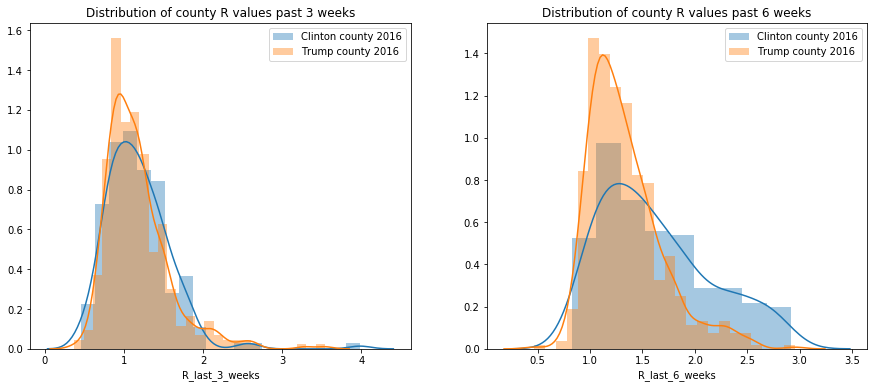

In [27]:
fig,ax = plt.subplots(1,2, figsize=(15,6))

for trump in range(0,2):
    county_sub = county_train[county_train["VotedTrump2016"]== trump]
    sns.distplot(county_sub["R_last_3_weeks"].dropna(), ax=ax[0])
ax[0].legend(["Clinton county 2016", "Trump county 2016"])

ax[0].set_title("Distribution of county R values past 3 weeks")


for trump in range(0,2):
    county_sub = county_train[county_train["VotedTrump2016"]== trump]
    sns.distplot(county_sub["R_last_6_weeks"].dropna(), ax=ax[1])
ax[1].legend(["Clinton county 2016", "Trump county 2016"])

ax[1].set_title("Distribution of county R values past 6 weeks")
fig.savefig("Rdist.png")

Interestingly, the distribution of R value from the last 3 weeks are very similar. When looking at R over the last 6 weeks however, we get a very different distribution. This suggests that we may want to look at R over other time periods.

# Process Data

The following functions process the data and create the X and y arrays.

In [28]:
def process_data(df):
    """
    Input: df (county or state-level df), state=True if state-level data, False if county-level data
    Returns: processed dataframe with all features
    """
    pd.set_option('mode.chained_assignment', None) #this is to make that slice error go away
    orders_columns = ['stay at home', '>50 gatherings',
                          '>500 gatherings', 'public schools', 'restaurant dine-in',
                          'entertainment/gym']
    df = add_state_orders_features_to_df(df, orders_columns)
    df["numeric_FIPS"] = pd.to_numeric(df["FIPS"])
        
    R_df = calculate_R(df["numeric_FIPS"])["R"].rename("R_last_3_weeks")
    R_df = pd.DataFrame(R_df)
    R_df["R_last_6_weeks"] = calculate_R(df["numeric_FIPS"], start_date = 46 )["R"]

    return pd.merge(df, R_df, left_on = "numeric_FIPS", right_index=True)
    
def select_features(df, x_columns, continuous_y=True):
    """
    Input: 
    Dataframe
    x_columns = list of strings of column names
    Continuous = True if using the continous Y variable, False if using binary
    Output: Y-variable array
    Note: this only works for county-level data
    """
    X = df[x_columns]
    X = X.apply(lambda x: x.fillna(x.mean()),axis=0) #impute mean for NA columns
    X = X[x_columns].to_numpy()

    if continuous_y == True:
        y = df['VotedTrump2016Cont'].to_numpy()
    else: 
        y = df['VotedTrump2016'].to_numpy() #Binary y variable for logistic regression

    return X, y

In [29]:
y_cont_train = county_train['PresElectCont'].to_numpy() #Continuous y variable for linear regression

x_columns = ['grocery', 'parks', 'residential', 'retail', 'transit', 'workplaces',  #Mobility
             'stay at home', '>50 gatherings', '>500 gatherings', 'public schools',
             'restaurant dine-in', 'entertainment/gym',
             'R_last_3_weeks', 'R_last_6_weeks' #R
             ]

X_train, y_cont_train_2016 = select_features(county_train, x_columns, continuous_y = True)
y_bin_train = select_features(county_train, x_columns, continuous_y = False)[1]

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn import ensemble

def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

def rmse_score(model, X, y):
    return np.sqrt(np.mean((y - model.predict(X)) ** 2))

#### Linear Regression Model with 2000 - 2016 Election Results

In [31]:
lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X_train, y_cont_train)
y_cont_train_pred = lin_model.predict(X_train)

print("Mean of y", y_cont_train.mean())
print("Std of y", y_cont_train.std())
print("\n")
print("RMSE:", rmse(y_cont_train,y_cont_train_pred))
print("RMSE when guessing the mean y:", rmse(y_cont_train,y_cont_train.mean()))
print("R^2:", lin_model.score(X_train, y_cont_train))
print("CV Score:", cross_val_score(lin_model, X_train, y_cont_train, cv=25, scoring=rmse_score).mean())

Mean of y 0.19468086397220635
Std of y 0.24747883572105747


RMSE: 0.21695084901020842
RMSE when guessing the mean y: 0.24747883572105747
R^2: 0.23149520836393078
CV Score: 0.22227850649688397


#### Linear Regression Model with only 2016 Election Results

In [32]:
lin_model_2016 = LinearRegression(fit_intercept=True)
lin_model_2016.fit(X_train, y_cont_train_2016)
y_cont_train_pred_2016 = lin_model.predict(X_train)

print("Mean of y", y_cont_train_2016.mean())
print("Std of y", y_cont_train_2016.std())
print("\n")
print("RMSE:", rmse(y_cont_train_2016, y_cont_train_pred_2016))
print("RMSE when guessing the mean y:", rmse(y_cont_train_2016, y_cont_train_2016.mean()))
print("R^2:", lin_model.score(X_train, y_cont_train_2016))
print("CV Score:", cross_val_score(lin_model_2016, X_train, y_cont_train_2016, cv=25, scoring=rmse_score).mean())

Mean of y 0.2976559249872579
Std of y 0.2953985421786718


RMSE: 0.27599449058389797
RMSE when guessing the mean y: 0.2953985421786718
R^2: 0.12706053097563763
CV Score: 0.2561443026813388


#### Logistic Regression Model

In [33]:
log_model = LogisticRegressionCV(cv=10, fit_intercept=True, solver='liblinear')
log_model.fit(X_train, y_bin_train)
y_bin_train_pred = log_model.predict(X_train)

print("Mean of y", y_bin_train.mean())
print("Std of y", y_bin_train.std())
print("\n")
print("CV Score:", log_model.score(X_train, y_bin_train))

Mean of y 0.8409616273693944
Std of y 0.36571186562868624


CV Score: 0.8409616273693944


#### Decision Tree Model

In [34]:
decision_tree_model = tree.DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_bin_train)
cross_val_score(decision_tree_model, X_train, y_bin_train, cv=25, scoring='accuracy').mean()

0.7695145368492226

#### Random Forest Model

In [35]:
random_forest_model = ensemble.RandomForestClassifier(20, random_state=42)
random_forest_model.fit(X_train, y_bin_train)
cross_val_score(random_forest_model, X_train, y_bin_train, cv=25, scoring='accuracy').mean()

0.8457336037863421

# Process Data & Test the Model

Now that we have decided what features to use, we'll look at the test data.

In [36]:
x_columns = ['grocery', 'parks', 'residential', 'retail', 'transit', 'workplaces',  #Mobility
             'stay at home', '>50 gatherings', '>500 gatherings', 'public schools',
             'restaurant dine-in', 'entertainment/gym',
             'R_last_3_weeks', 'R_last_6_weeks' #R
            ]

county_test = process_data(county_test)

#County Level Test data
y_test_cont = county_test['PresElectCont'].to_numpy()
X_test, y_test_cont_2016 = select_features(county_test, x_columns, continuous_y=True)
y_test_bin = select_features(county_test, x_columns, continuous_y=False)[1]

#### Linear Model Testing Accuracy

In [37]:
print('Linear Model (2000-2016):', rmse_score(lin_model, X_test, y_test_cont))
print('Linear Model (2016):', rmse_score(lin_model_2016, X_test, y_test_cont_2016))

Linear Model (2000-2016): 0.20916747477605213
Linear Model (2016): 0.2432151943972082


#### Binary Model Testing Accuracy

In [38]:
print('Logistic Regression Test Accuracy:', log_model.score(X_test, y_test_bin))
print('Decision Tree Test Accuracy:', decision_tree_model.score(X_test, y_test_bin))
print('Random Forest Test Accuracy:', random_forest_model.score(X_test, y_test_bin))

Logistic Regression Test Accuracy: 0.8394833948339483
Decision Tree Test Accuracy: 0.8136531365313653
Random Forest Test Accuracy: 0.8837638376383764


# Plotting Predictions

Now that we have tested our data, let's look at how model sees America.

In [39]:
predict_df = process_data(county_merged_df)
predict_df.loc[:, x_columns] = predict_df.loc[:, x_columns].apply(lambda x: x.fillna(x.mean()),axis=0)
predict_df['Lin_Prediction'] = lin_model.predict(predict_df.loc[:, x_columns])
predict_df['Lin_2016_Prediction'] = lin_model_2016.predict(predict_df.loc[:, x_columns])
predict_df['Log_Prediction'] = log_model.predict(predict_df.loc[:, x_columns])
predict_df['Tree_Prediction'] = decision_tree_model.predict(predict_df.loc[:, x_columns])
predict_df['Forest_Prediction'] = random_forest_model.predict(predict_df.loc[:, x_columns])

predict_df.head()

,FIPS,STATEFP,CountyName,StateName,State,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,...,entertainment/gym same for whole state,entertainment/gym relative to state,numeric_FIPS,R_last_3_weeks,R_last_6_weeks,Lin_Prediction,Lin_2016_Prediction,Log_Prediction,Tree_Prediction,Forest_Prediction
0,01001,01,Autauga,AL,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,...,True,0.0,1001,1.193478,1.432169,0.220140,0.296730,1,1,1
1,01003,01,Baldwin,AL,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,...,True,0.0,1003,1.375101,1.489808,0.239236,0.325869,1,1,1
2,01005,01,Barbour,AL,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,...,True,0.0,1005,1.193478,1.432169,0.299379,0.425049,1,1,1
3,01007,01,Bibb,AL,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,...,True,0.0,1007,1.242232,1.242232,0.285370,0.403022,1,1,1
4,01009,01,Blount,AL,Alabama,737519.0,737504.0,737497.0,737500.0,737503.0,...,True,0.0,1009,1.193478,1.010837,0.235288,0.325322,1,1,1


In [40]:
print('Linear Model Actual RMSE (2000-2016):', rmse(predict_df['Lin_Prediction'],  predict_df['PresElectCont']))
print('Linear Model Actual RMSE (2016):', rmse(predict_df['Lin_2016_Prediction'],  predict_df['VotedTrump2016Cont']))
print('Logistic Regression Actual Accuracy:', log_model.score(predict_df.loc[:, x_columns], predict_df['VotedTrump2016']))
print('Decision Tree Actual Accuracy:', decision_tree_model.score(predict_df.loc[:, x_columns], predict_df['VotedTrump2016']))
print('Random Forest Actual Accuracy:', random_forest_model.score(predict_df.loc[:, x_columns], predict_df['VotedTrump2016']))

Linear Model Actual RMSE (2000-2016): 0.21599414124688057
Linear Model Actual RMSE (2016): 0.24779215435643778
Logistic Regression Actual Accuracy: 0.8403547671840355
Decision Tree Actual Accuracy: 0.9623059866962306
Random Forest Actual Accuracy: 0.974870657797487


In [41]:
actual_map_lin = county_shp.merge(predict_df.loc[:, ('PresElectCont','FIPS')], on='FIPS').cx[-130:-50, 20:]
actual_map_lin_2016 = county_shp.merge(predict_df.loc[:, ('VotedTrump2016Cont','FIPS')], on='FIPS').cx[-130:-50, 20:]
actual_map_bin = county_shp.merge(predict_df.loc[:, ('VotedTrump2016','FIPS')], on='FIPS').cx[-130:-50, 20:]

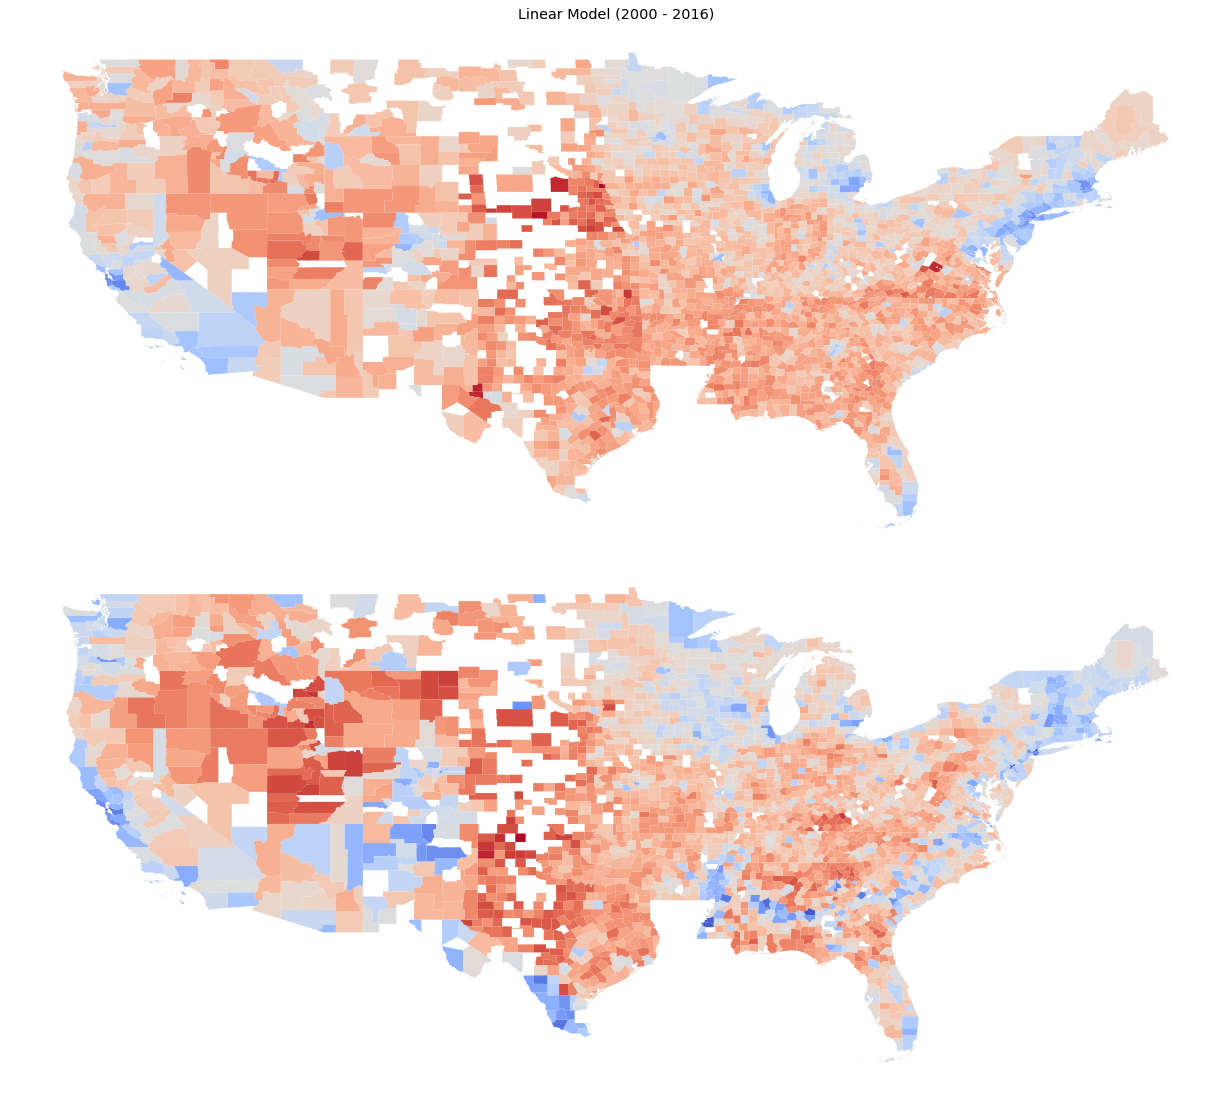

In [42]:
fig, axes = plt.subplots(2, 1, figsize=(25,15), sharex=True, sharey=True)
trump_col = mpatches.Patch(color='red',alpha = 1.0, label='Trump')
clinton_col = mpatches.Patch(color='blue',alpha = 1.0, label='Clinton')


predicted_map = county_shp.merge(predict_df.loc[:, ('Lin_Prediction', 'FIPS')], on='FIPS').cx[-130:-50, 20:]
predicted_map.plot(ax=axes[0], column='Lin_Prediction', cmap='coolwarm', linewidth=0, edgecolor='white')
actual_map_lin.plot(ax=axes[1], column='PresElectCont', cmap='coolwarm', linewidth=0, edgecolor='white')
plt.suptitle('Linear Model (2000 - 2016)', y=1.01, size='x-large')
axes[0].set_axis_off()
axes[1].set_axis_off()

plt.tight_layout();

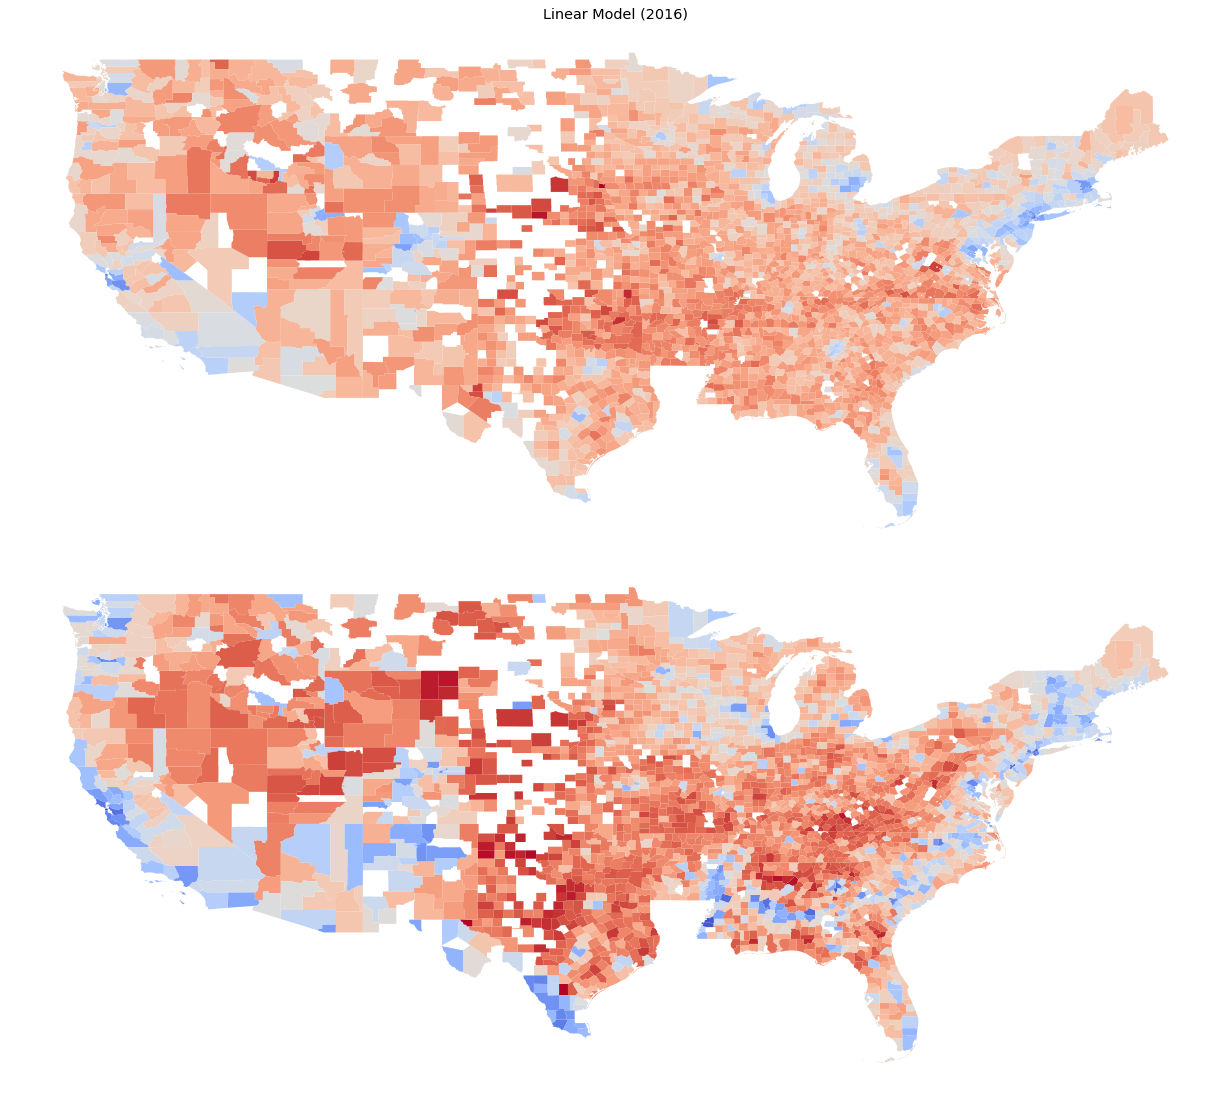

In [43]:
fig, axes = plt.subplots(2, 1, figsize=(25,15), sharex=True, sharey=True)

predicted_map = county_shp.merge(predict_df.loc[:, ('Lin_2016_Prediction', 'FIPS')], on='FIPS').cx[-130:-50, 20:]
predicted_map.plot(ax=axes[0], column='Lin_2016_Prediction', cmap='coolwarm', linewidth=0, edgecolor='white')
actual_map_lin_2016.plot(ax=axes[1], column='VotedTrump2016Cont', cmap='coolwarm', linewidth=0, edgecolor='white')
plt.suptitle('Linear Model (2016)', y=1.01, size='x-large')
axes[0].set_axis_off()
axes[1].set_axis_off()

plt.tight_layout();

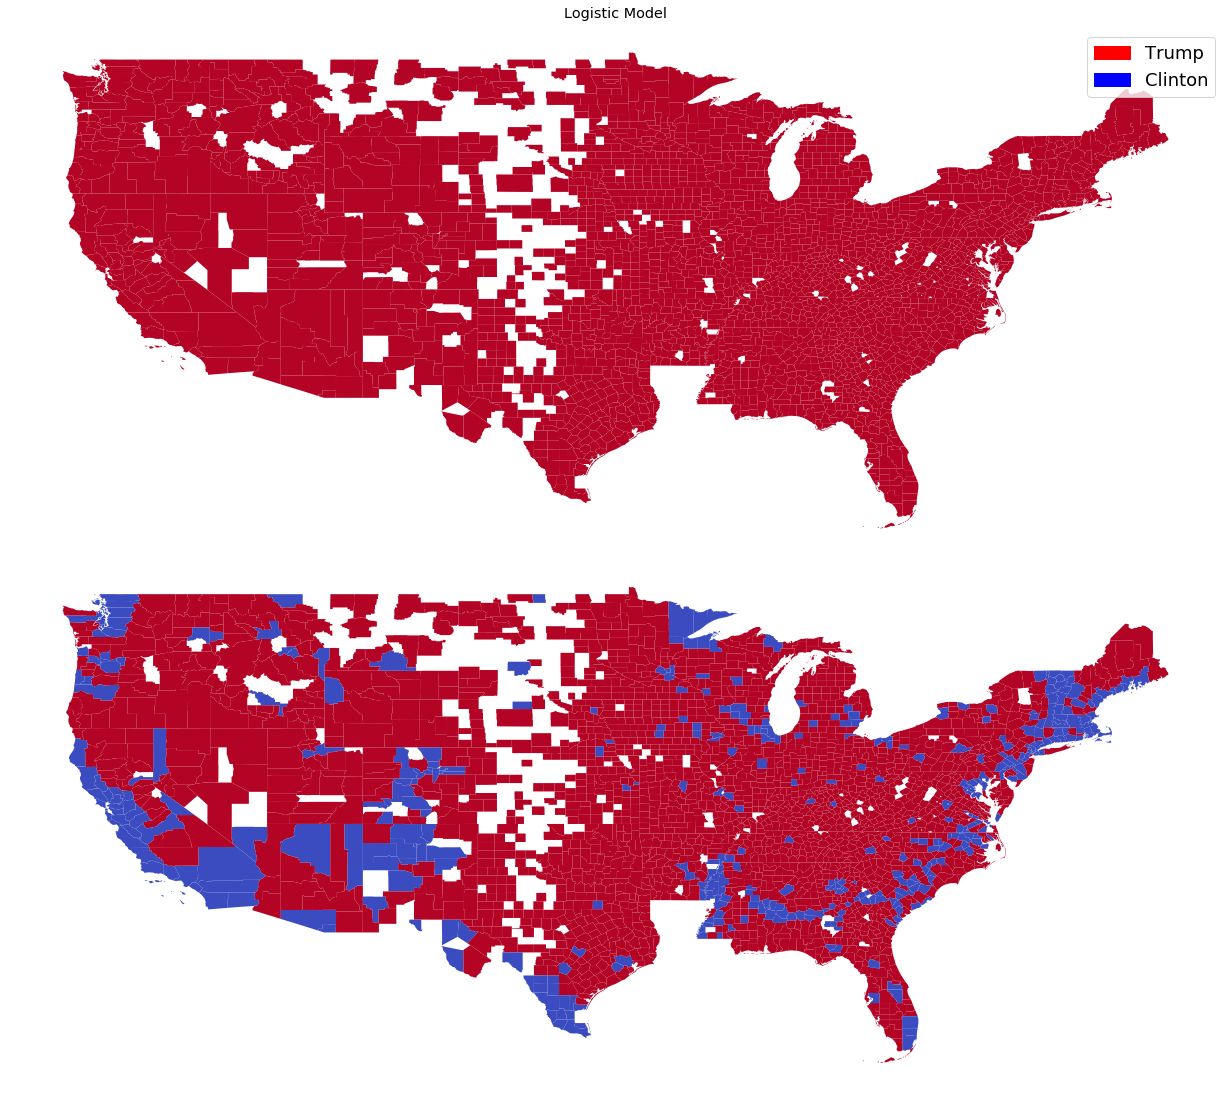

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(25,15), sharex=True, sharey=True)

predicted_map = county_shp.merge(predict_df.loc[:, ('Log_Prediction', 'FIPS')], on='FIPS').cx[-130:-50, 20:]
predicted_map.plot(ax=axes[0], column='Log_Prediction', cmap='coolwarm', linewidth=0, edgecolor='white', vmin=0, vmax=1)
actual_map_bin.plot(ax=axes[1], column='VotedTrump2016', cmap='coolwarm', linewidth=0, edgecolor='white')
plt.suptitle('Logistic Model', y=1.01, size='x-large')
axes[0].legend(handles = [trump_col, clinton_col], loc =1,prop={'size':18})
axes[0].set_axis_off()
axes[1].set_axis_off()

plt.tight_layout();

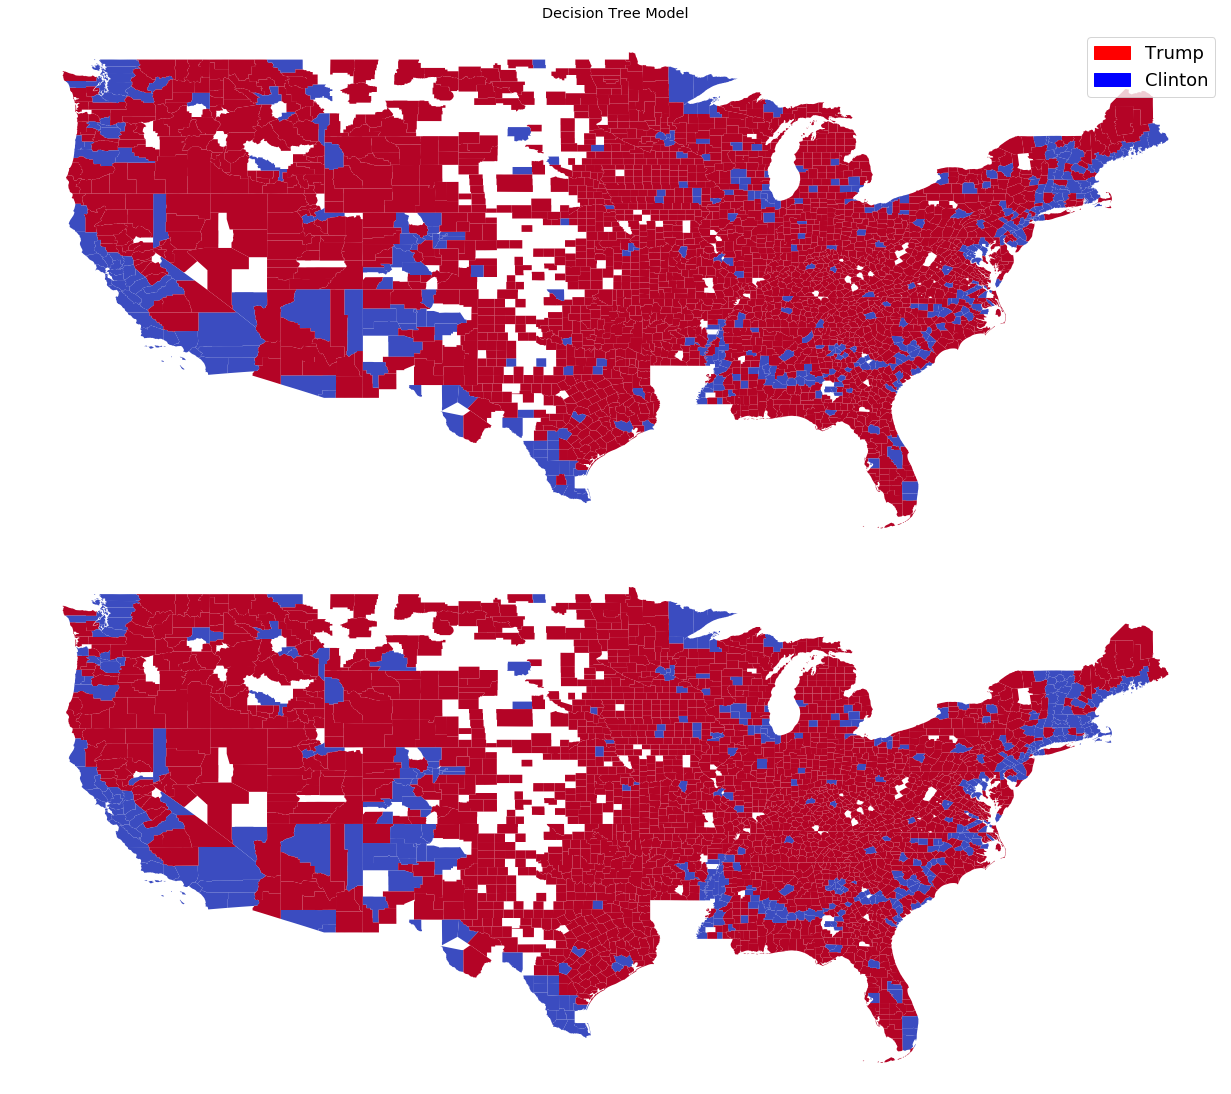

In [45]:
fig, axes = plt.subplots(2, 1, figsize=(25,15), sharex=True, sharey=True)

predicted_map = county_shp.merge(predict_df.loc[:, ('Tree_Prediction', 'FIPS')], on='FIPS').cx[-130:-50, 20:]
predicted_map.plot(ax=axes[0], column='Tree_Prediction', cmap='coolwarm', linewidth=0, edgecolor='white')
actual_map_bin.plot(ax=axes[1], column='VotedTrump2016', cmap='coolwarm', linewidth=0, edgecolor='white')
plt.suptitle('Decision Tree Model', y=1.01, size='x-large')
axes[0].legend(handles = [trump_col, clinton_col], loc =1,prop={'size':18})
axes[0].set_axis_off()
axes[1].set_axis_off()

plt.tight_layout();

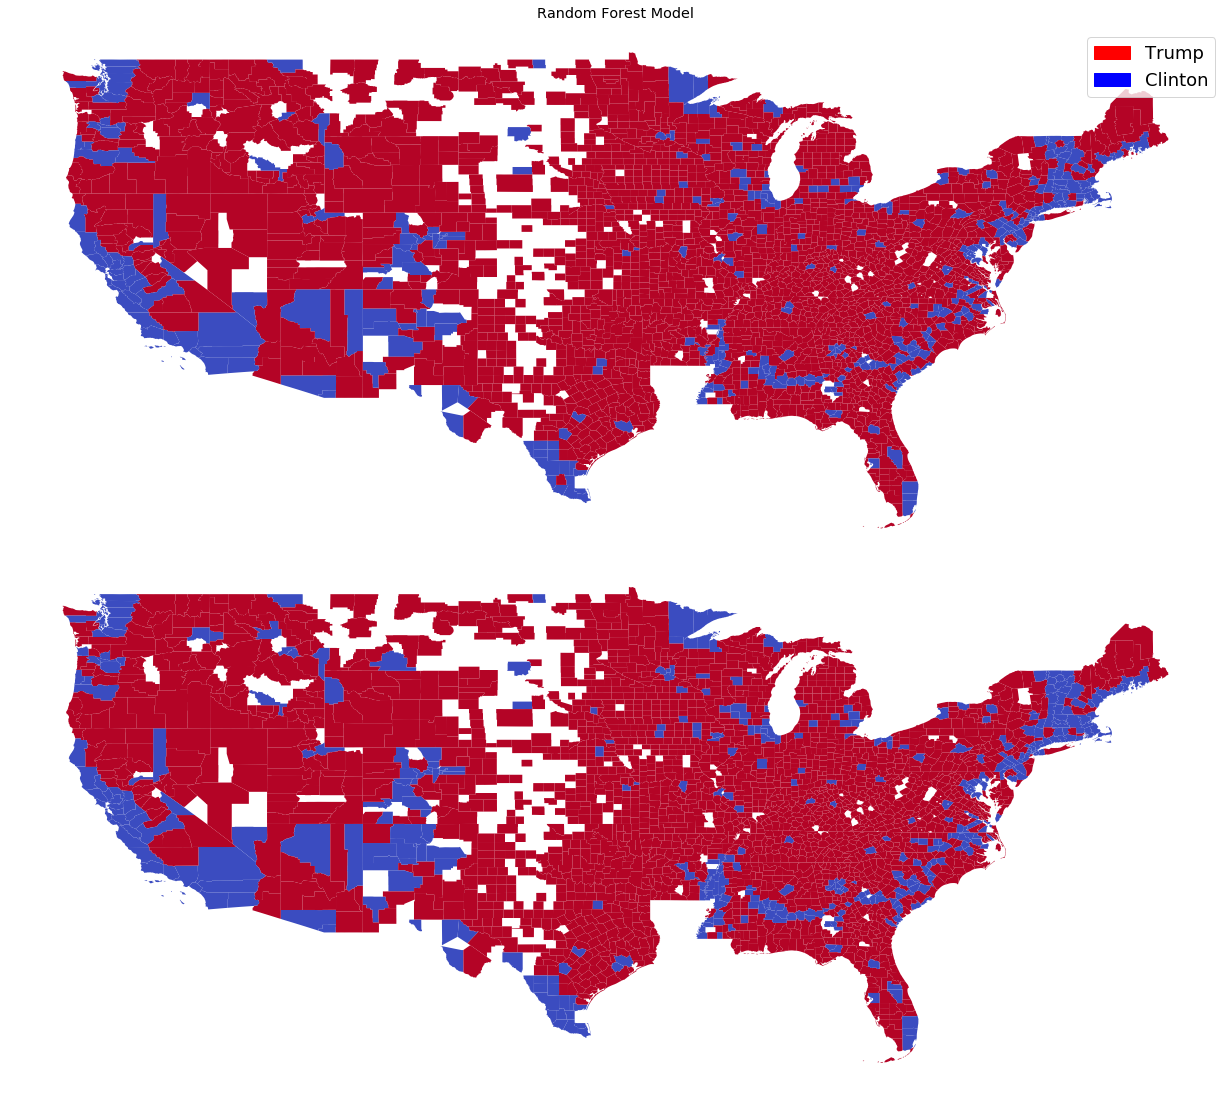

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(25,15), sharex=True, sharey=True)

predicted_map = county_shp.merge(predict_df.loc[:, ('Forest_Prediction', 'FIPS')], on='FIPS').cx[-130:-50, 20:]
predicted_map.plot(ax=axes[0], column='Forest_Prediction', cmap='coolwarm', linewidth=0, edgecolor='white')
actual_map_bin.plot(ax=axes[1], column='VotedTrump2016', cmap='coolwarm', linewidth=0, edgecolor='white')
plt.suptitle('Random Forest Model', y=1.01, size='x-large')
axes[0].legend(handles = [trump_col, clinton_col], loc =1,prop={'size':18})
axes[0].set_axis_off()
axes[1].set_axis_off()

plt.tight_layout();

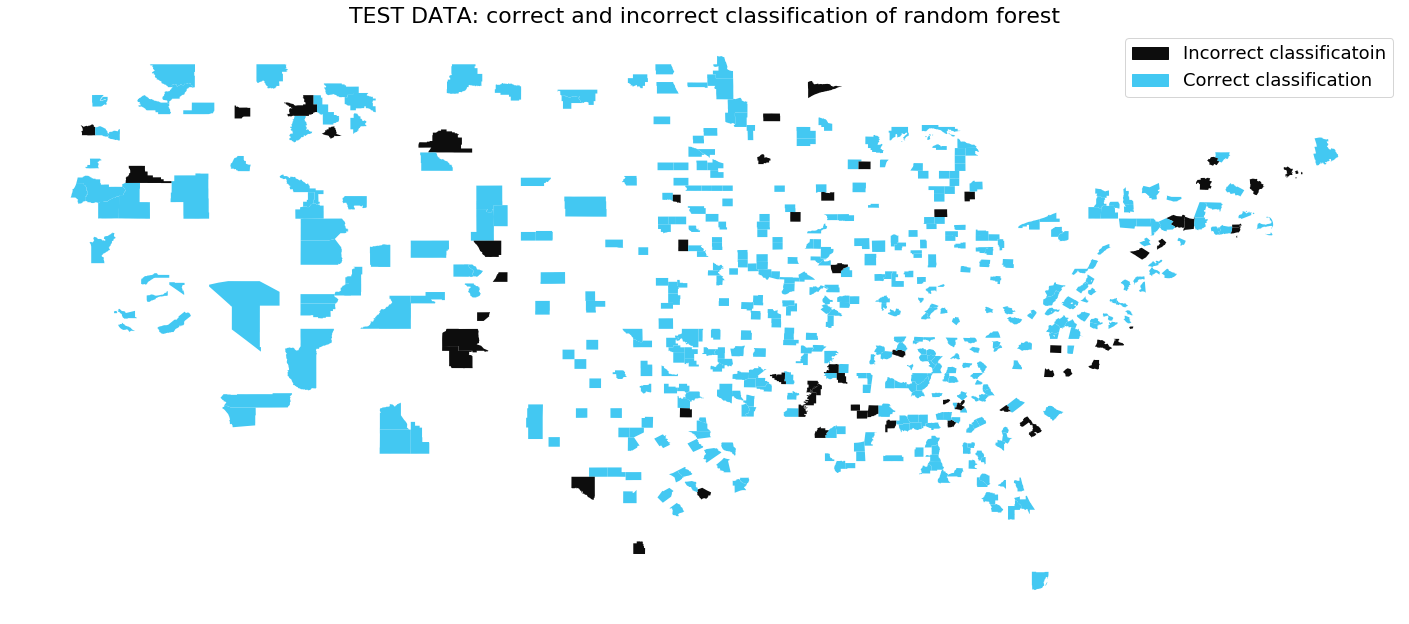

In [72]:
from matplotlib.colors import LinearSegmentedColormap

blue_cust = [67/255, 200/255, 242/255]
black_cust = [13/255,13/255,13/255]

nodes = [0, 1]  # positions for each color from 0-1
color_scheme = [black_cust, blue_cust]  # corresponds to nodes
custom_cmap = LinearSegmentedColormap.from_list("blueblack", list(zip(nodes, color_scheme)))
custom_cmap.set_under(blue_cust)  # set values under vmin to gray
custom_cmap.set_over(black_cust)  # set values over vmax to red
plt.register_cmap(cmap=custom_cmap)


predicted_test_counties = predicted_map[predicted_map["FIPS"].isin(county_test["FIPS"])]
actual_map_bin_test_counties = actual_map_bin[actual_map_bin["FIPS"].isin((county_test["FIPS"]))]

predicted_test_counties["Forest_Correct"] = (predicted_test_counties["Forest_Prediction"]==actual_map_bin_test_counties["VotedTrump2016"]).astype(int)
bfig, axes = plt.subplots(1, 1, figsize=(25,15), sharex=True, sharey=True)

predicted_test_counties.plot(ax=axes, column='Forest_Correct', cmap=custom_cmap, linewidth=0, edgecolor='white')

axes.set_title("TEST DATA: correct and incorrect classification of random forest", size = 22)

axes.set_axis_off()


test_wrong_col = mpatches.Patch(color=black_cust,alpha = 1.0, label='Incorrect classificatoin')
test_correct_col = mpatches.Patch(color=blue_cust,alpha = 1.0, label='Correct classification')
axes.legend(handles=[test_wrong_col,test_correct_col],prop={'size':18})

